In [104]:
import pandas as pd
from espn_api.football import League
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt

In [105]:
#Fetch league data

# Initialize league
league_id = 26347
espn_s2 = 'AECJTHUB5QQ41P4C5vinQpk7fGVA6h%2BnbM7tsN7mhlpWupwMWzVIKnKFd219nyX3Ss37wALT0z0fYoIOd9zieRZOE6I3nG%2BSSEUksFfA43gw8Hv3ywuj9PXh1fTxJlA9O%2FPfzY9GgfQH1OwPqQsmvWx0Zt7YOZKaBvy1ORbTZfgMfOZCVkqNYWMpBZzHCzAun99t%2FS3i24onjEXOch2vI9E%2Ff4y5%2BRBiE%2BaPaOlfnMTy1d3DbG1E%2FYqnZzNWbT3Yk3%2FFq7cLHbHTL1HF4Ouvgf6N'
swid = '{C3FE8278-A2E3-4D18-86D2-0154124A1F16}'
year = 2023  # Replace with the specific year you want

# Initialize the league for the specific year
league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid, debug=False)


In [106]:
#Create get_matchup_scores function
def get_matchup_scores(league, year):
    matchup_scores = []

    # Iterate through each week
    for week in range(1, league.current_week + 1):
        # Get the box scores for the current week
        box_scores = league.box_scores(week)

        # Iterate through each game in the box scores
        for game_id, game in enumerate(box_scores, start=1):
            home_team = game.home_team
            away_team = game.away_team

            # Retrieve the scores for each team in the game
            home_score = game.home_score
            away_score = game.away_score

            # Additional information
            season = year
            home_projected = game.home_projected
            away_projected = game.away_projected 

            matchup_info = {
                "game_id": game_id,
                "season": season,
                "week": week,
                "home_team": home_team.team_name,
                "home_team_id": home_team.team_id,
                "home_score": home_score,
                "away_team": away_team.team_name,
                "away_team_id": away_team.team_id,
                "away_score": away_score,
                "home_projected": home_projected,
                "away_projected": away_projected,
            }

            matchup_scores.append(matchup_info)

    return matchup_scores

In [107]:
matchup_scores = get_matchup_scores(league, year)

In [108]:
#Training Data Specific Cleaning
def training_cleaning(matchup_scores):
    matchups_df = pd.DataFrame(matchup_scores)
    matchups_df['home_team_win'] = (matchups_df['home_score'] > matchups_df['away_score']).astype(int)
    max_week = matchups_df['week'].max()
    matchups_df = matchups_df[matchups_df['week'] != max_week]
    return matchups_df
matchups_df = training_cleaning(matchup_scores)

In [109]:
#Create a historical standings table - turn into function
def create_standings(matchups_df):
    # Create an empty DataFrame to store the standings
    standings_df = pd.DataFrame()
    # Get a list of all unique team IDs
    team_ids = matchups_df['home_team_id'].unique()
    # Determine the maximum number of weeks in the dataset
    max_week = matchups_df['week'].max()
    # Iterate through each team
    for team_id in team_ids:
        # Create a DataFrame for the current team with all weeks' statistics
        team_df = pd.DataFrame({
            'team_id': [team_id] * max_week,
            'prior_to_week': list(range(1, max_week + 1)),
            'wins': 0,
            'losses': 0,
            'points_for': 0,
            'points_against': 0,
            'win_percentage': 0,
            'points_per_game': 0,
            'points_against_per_game': 0
        })

        # Iterate through each week
        for week in range(1, max_week + 1):
            # Filter the DataFrame to get data prior to the current week
            prior_to_week_df = matchups_df[matchups_df['week'] < week]

            # Filter the DataFrame to get matches involving the current team
            team_matches = prior_to_week_df[(prior_to_week_df['home_team_id'] == team_id) | (prior_to_week_df['away_team_id'] == team_id)]

            # Calculate team statistics
            team_wins = sum(team_matches['home_team_id'] == team_id)
            team_losses = sum(team_matches['away_team_id'] == team_id)
            team_points_for = sum(team_matches.loc[team_matches['home_team_id'] == team_id, 'home_score']) + sum(team_matches.loc[team_matches['away_team_id'] == team_id, 'away_score'])
            team_points_against = sum(team_matches.loc[team_matches['home_team_id'] == team_id, 'away_score']) + sum(team_matches.loc[team_matches['away_team_id'] == team_id, 'home_score'])
            total_games = team_wins + team_losses
            win_percentage = team_wins / total_games if total_games > 0 else 0
            points_per_game = team_points_for / total_games if total_games > 0 else 0
            points_against_per_game = team_points_against / total_games if total_games > 0 else 0

            # Update the current week's statistics in the team's DataFrame
            team_df.loc[week - 1, 'wins'] = team_wins
            team_df.loc[week - 1, 'losses'] = team_losses
            team_df.loc[week - 1, 'points_for'] = team_points_for
            team_df.loc[week - 1, 'points_against'] = team_points_against
            team_df.loc[week - 1, 'win_percentage'] = win_percentage
            team_df.loc[week - 1, 'points_per_game'] = points_per_game
            team_df.loc[week - 1, 'points_against_per_game'] = points_against_per_game

        # Append the team's DataFrame to the standings DataFrame
        standings_df = pd.concat([standings_df, team_df], ignore_index=True)
    return standings_df

standings_df = create_standings(matchups_df)

In [110]:
def matchups_preprocessing(matchups_df,standings_df):
    #Column creation and set index
    matchups_df['matchup_id'] =  matchups_df['season'].astype(str) + matchups_df['week'].astype(str) + matchups_df['game_id'].astype(str)
    matchups_df.set_index('matchup_id', inplace=True)

    # Merge historical standings into matchup data to get team stats prior to each matchup

    # Merge 'standings_df' into 'df' for home team's statistics
    matchups_df = pd.merge(matchups_df, standings_df, how='left', left_on=['home_team_id', 'week'], right_on=['team_id', 'prior_to_week'])
    # Rename the columns for home team's statistics
    matchups_df = matchups_df.rename(columns={
        'win_percentage': 'home_team_win_pct',
        'points_per_game': 'home_team_ppg'
    })
    # Drop the redundant columns from the merge
    matchups_df = matchups_df.drop(['team_id', 'prior_to_week', 'wins', 'losses', 'points_for', 'points_against', 'points_against_per_game'], axis=1)
    # Merge 'standings_df' into 'df' for away team's statistics
    matchups_df = pd.merge(matchups_df, standings_df, how='left', left_on=['away_team_id', 'week'], right_on=['team_id', 'prior_to_week'])
    # Rename the columns for away team's statistics
    matchups_df = matchups_df.rename(columns={
        'win_percentage': 'away_team_win_pct',
        'points_per_game': 'away_team_ppg'
    })
    # Drop the redundant columns from the merge
    matchups_df = matchups_df.drop(['team_id', 'prior_to_week', 'wins', 'losses', 'points_for', 'points_against', 'points_against_per_game'], axis=1)
    return matchups_df
matchups_df = matchups_preprocessing(matchups_df,standings_df)

### Training

In [111]:
# Specify the features and target variable
X = matchups_df[['home_team_win_pct', 'away_team_win_pct','home_team_ppg','away_team_ppg', 'season','away_projected','home_projected','week']] # Features
y = matchups_df['home_team_win']

#Split data based into training and test sets (Weeks 1-5, Weeks 7-9)) 
X_train = X[X['week'] < 6]
X_test = X[X['week'] > 6]
y_train = y[X_train.index]
y_test = y[X_test.index]

In [112]:
#Fit model
# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
# Fit the classifier to the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [113]:
#Calc Metrics

# Calculate accuracy on training and test data
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get probability estimates for both training and test data
y_train_prob = xgb_classifier.predict_proba(X_train)
y_test_prob = xgb_classifier.predict_proba(X_test)

# Calculate log loss on training and test data
test_log_loss = log_loss(y_test, y_test_prob)
print(f"Test Log Loss: {test_log_loss:.4f}")



Test Accuracy: 0.4667
Test Log Loss: 1.5223


In [114]:
# Baseline Model Using ESPN Projections
def baseline_pred(dataset):
    #if home team has higher projection, predict home team win
    dataset['home_team_win_pred'] = (dataset['home_projected'] > dataset['away_projected']).astype(int)
    #check accuracy of baseline model
    dataset['home_team_win'] = (dataset['home_score'] > dataset['away_score']).astype(int)
    dataset['home_team_win_correct'] = (dataset['home_team_win'] == dataset['home_team_win_pred']).astype(int)
    baseline_accuracy = dataset['home_team_win_correct'].mean()
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")

baseline_pred(training_cleaning(get_matchup_scores(league, year)))

Baseline accuracy: 0.6000


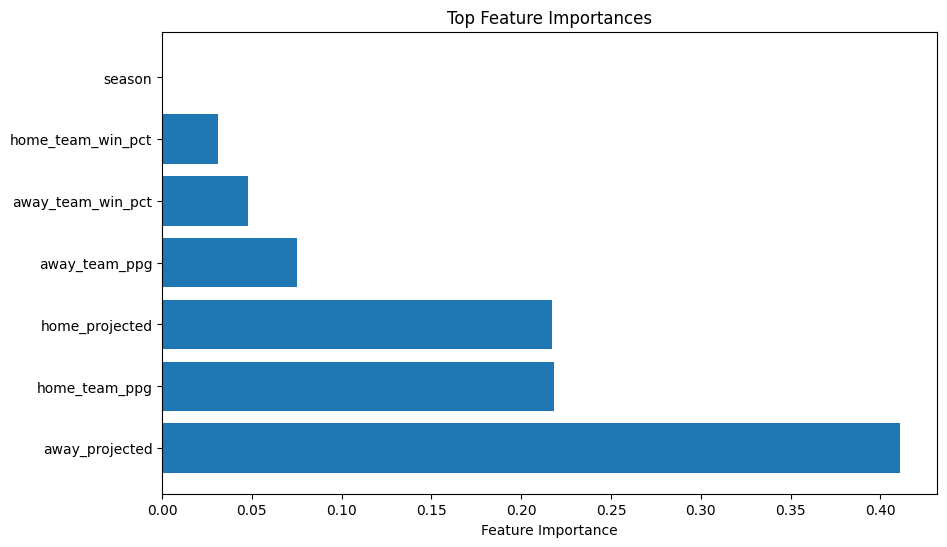

In [115]:
# Check feature importances
#Turn into function with N as input
feature_importances = xgb_classifier.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
N = 7  # Change N to the number of top features you want to display
top_features = importance_df.head(N)


# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(N), top_features['Importance'], align='center')
plt.yticks(range(N), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.show()

In [116]:
#Pickle the model
import pickle
filename = 'xgb_win_pred_model.sav'
pickle.dump(xgb_classifier, open(filename, 'wb'))

### Pull matchups, filter on newest, update standings?, preprocess, predict_proba

In [128]:
# Get current standings
def get_current_standings(league,year):
    all_matchups = get_matchup_scores(league, year)
    all_matchups = pd.DataFrame(all_matchups)
    all_matchups['home_team_win'] = (all_matchups['home_score'] > all_matchups['away_score']).astype(int)
    standings_df = create_standings((all_matchups))
    max_week = standings_df['prior_to_week'].max()
    standings_df = standings_df[standings_df['prior_to_week'] == max_week]
    return standings_df
standings_df = get_current_standings(league,year)
standings_df

,team_id,prior_to_week,wins,losses,points_for,points_against,win_percentage,points_per_game,points_against_per_game
9,9,10,4,5,809,742,0.444444,89.888889,82.444444
19,8,10,5,4,819,875,0.555556,91.000000,97.222222
29,1,10,6,3,831,814,0.666667,92.333333,90.444444
39,2,10,4,5,799,905,0.444444,88.777778,100.555556
49,10,10,5,4,871,864,0.555556,96.777778,96.000000
59,4,10,5,4,1000,720,0.555556,111.111111,80.000000
69,3,10,6,3,801,968,0.666667,89.000000,107.555556
79,5,10,3,6,688,891,0.333333,76.444444,99.000000
89,6,10,3,6,871,737,0.333333,96.777778,81.888889
99,7,10,4,5,858,831,0.444444,95.333333,92.333333


In [129]:
# Get new matchups
def get_current_matchups(league, year):
    all_matchups = get_matchup_scores(league, year)
    matchups_df = pd.DataFrame(all_matchups)
    max_week = matchups_df['week'].max()
    matchups_df = matchups_df[matchups_df['week'] == max_week]
    return matchups_df
current_matchups = get_current_matchups(league,year)
current_matchups

,game_id,season,week,home_team,home_team_id,home_score,away_team,away_team_id,away_score,home_projected,away_projected
45,1,2023,10,Team Gibsin,10,0.0,Jack's Krevice,3,0.0,94.86,89.81
46,2,2023,10,The U23 Bobby Football Team,6,0.0,Monty Men,1,0.0,89.04,88.93
47,3,2023,10,Gastropod Gunmen,8,23.0,Demarco Murray,7,0.0,81.27,88.40
48,4,2023,10,DA LOVE DOCTER,5,0.0,Team LoSardo,2,8.0,77.48,95.81
49,5,2023,10,Team Gibson,4,0.0,Team SOOO GOOD,9,5.0,81.34,77.46


In [130]:
matchups_cleaned = matchups_preprocessing(current_matchups,standings_df)
matchups_cleaned


,game_id,season,week,home_team,home_team_id,home_score,away_team,away_team_id,away_score,home_projected,away_projected,home_team_win_pct,home_team_ppg,away_team_win_pct,away_team_ppg
0,1,2023,10,Team Gibsin,10,0.0,Jack's Krevice,3,0.0,94.86,89.81,0.555556,96.777778,0.666667,89.000000
1,2,2023,10,The U23 Bobby Football Team,6,0.0,Monty Men,1,0.0,89.04,88.93,0.333333,96.777778,0.666667,92.333333
2,3,2023,10,Gastropod Gunmen,8,23.0,Demarco Murray,7,0.0,81.27,88.40,0.555556,91.000000,0.444444,95.333333
3,4,2023,10,DA LOVE DOCTER,5,0.0,Team LoSardo,2,8.0,77.48,95.81,0.333333,76.444444,0.444444,88.777778
4,5,2023,10,Team Gibson,4,0.0,Team SOOO GOOD,9,5.0,81.34,77.46,0.555556,111.111111,0.444444,89.888889


In [131]:
#Load the model and make predictions
# Load the pickled model
filename = 'xgb_win_pred_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# Use the loaded model to make predictions
predictions = loaded_model.predict(matchups_cleaned)

ValueError: Feature shape mismatch, expected: 8, got 15

In [ ]:
predictions

array([0, 0, 0, 0, 0])